## Enviroment from openAI gym , slighlty twisted so that it bhevaes as MDP, knows the dynamichs of the system

https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

In [0]:
## openAI gym , Frozen Lake Enviroment

import numpy as np
import sys
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}

class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col
        def inc(row, col, a):
            if a==0: # left
                col = max(col-1,0)
            elif a==1: # down
                row = min(row+1,nrow-1)
            elif a==2: # right
                col = min(col+1,ncol-1)
            elif a==3: # up
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))
        
        # obtain one-step dynamics for dynamic programming setting
        self.P = P

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        if close:
            return
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            return outfile


In [0]:
import gym
import numpy as np
import copy

In [0]:
env = FrozenLakeEnv()


In [4]:
print(env.observation_space)
print(env.action_space)
#total number os stats
print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


# Iterative Policy evaluation

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vQ8g5QRtFDveIf-V8vcYNPQ3zueAwmlLFmwPUGwg8LwXcBzlcwHx5Rsxj-Chcvv7k0euSzjHbL68K1e/pub?w=960&h=720)

In [0]:
def policy_evaluation(env, policy, gamma =1 , theta=1e-8):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for each_state in range(env.nS):
            Vs = 0
            for action, action_prob in enumerate(policy[each_state]):
                for prob, next_state, imediate_reward, done in env.P[each_state][action]:
                    Vs += action_prob * prob * (imediate_reward + gamma* V[next_state])
                    
            delta = max(delta, np.abs(V[each_state] - Vs))
            V[each_state] = Vs
        if delta < theta:
            break
    return V
                    
                    
                

In [0]:
random_policy = np.ones([env.nS, env.nA]) / env.nA


In [0]:
V = policy_evaluation(env, random_policy)

In [18]:
V

array([0.01393977, 0.01163091, 0.02095297, 0.01047648, 0.01624865,
       0.        , 0.04075153, 0.        , 0.03480619, 0.08816993,
       0.14205316, 0.        , 0.        , 0.17582037, 0.43929118,
       0.        ])

In [0]:
import matplotlib.pyplot as plt

def plot(V):
    V_sq = np.reshape(V, (4,4))
    #plotting
    figure = plt.figure(figsize = (6,6))
    axis = figure.add_subplot(111)
    im = axis.imshow(V_sq, cmap = 'cool')
    for (j,i), label in np.ndenumerate(V_sq):
        axis.text(i ,j , np.round(label, 5), ha ='center', va ='center', fontsize =14)
    
    #plt.tick_params(bottom=False, left =False, labelbottom = False, labellefft= False)
    plt.title('State-Value Function')
    plt.show()

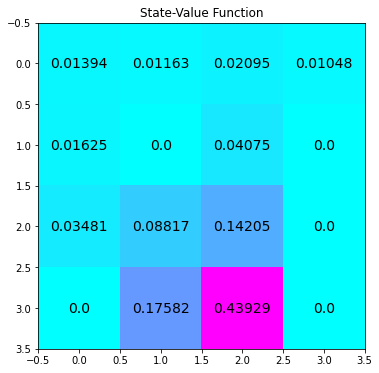

In [40]:
plot(V)

In [0]:
# Obtaining q value from v 
# obtainf action value from sate value 
# the function takes the argeument  as enviroment, state (each sate has different actions up, down, keft ,right) and gamma


# obtain Q from V
## Obtain Action values for each state from state Values



![alt text](https://docs.google.com/drawings/d/e/2PACX-1vQpmuUfrf4cqrU3hvumN8y9jf9GdNjUqUPgmFvJaHj-OlP9w50qYR_09WkMdlh3DBcjBlLeMa5Igzkf/pub?w=960&h=720)

In [0]:
def q_value_from_v(env, V, s, gamma = 1):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob *(reward + gamma *V[next_state])
    return q

In [43]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
  Q[s] = q_value_from_v(env, V, s)
print("action value function")
print(Q)

action value function
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


In [50]:
V

array([0.01393977, 0.01163091, 0.02095297, 0.01047648, 0.01624865,
       0.        , 0.04075153, 0.        , 0.03480619, 0.08816993,
       0.14205316, 0.        , 0.        , 0.17582037, 0.43929118,
       0.        ])

# Policy Improvement

It is a very simple algorimt where we find the best policy from action values computed.

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vS_h8y9eC0neqwmQhZhk2BRYL_S7vlGfBmWr86xJNmPFOfsjAKfeRDCirQ9Kp5zwRk82N5ej46AiHvE/pub?w=960&h=720)

In [0]:
def policy_improvement(env, V, gamma =1):
  policy = np.zeros([env.nS, env.nA])  / env.nA
  for each_state in range(env.nS):
    q = q_value_from_v(env,V,s, gamma)
    best_a = np.argwhere(q == np.max(q)).flatten()
    #print(best_a)
    # stochastic policy
    
    policy[each_state] =  np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
    #print(policy[each_state])

  return policy

In [54]:
policy_improvement(env,V)

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

# Policy Iteration

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vSYhGpMYmfc9LV7UlhaS9ZCyRZqzzznJPiT6Grix1f1x2KEeRaoZX0GTJRMMfyLXgD8c5lRvYAc5ooG/pub?w=960&h=720)

In [0]:
def polcy_iterattion(env,gamma=1, theta = 1e-8):
  policy = np.ones([env.nS, env.nA]) / env.nA
  while True:
    V = policy_evaluation(env, policy, gamma, theta)
    new_policy = policy_improvement(env,V)
    # if policy is not improved then break
    if (new_policy == policy).all():
      break
    policy = copy.copy(new_policy)

  return policy, V

In [57]:
polcy_iterattion(env)

(array([[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]),
 array([0.01393977, 0.01163091, 0.02095297, 0.01047648, 0.01624865,
        0.        , 0.04075153, 0.        , 0.03480619, 0.08816993,
        0.14205316, 0.        , 0.        , 0.17582037, 0.43929118,
        0.        ]))

# Truncated Policy Iteration

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vRg3Z6N6ybnKixMHXc4seamtkl-RTN_qN-VuI3SbhS1TBujyMtAdDgyhbMWhZ0TU6-gy8D-NC8FfFT_/pub?w=960&h=720)

In [0]:
def truncated_policy_eval(env, policy,V, max_it =1, gamma =1 ):
  num_it = 0
  while num_it < max_it:
    for s in range(env.nS):
      v = 0
      q = q_value_from_v(env, V, s, gamma)
      for a, action_prob in enumerate(policy[s]):
        v += action_prob * q[a]
      V[s] =v 
    num_it +=1 

  return V


In [0]:
def truncated_policy_iter(env, max_it =1, gamma =1 , theta = 1e-8):
  V = np.zeros(env.nS)
  policy = np.zeros([env.nS], env.nA)/ env.nA
  while true:
    polciy = policy_improvement(env,V)
    old_V = copy.copy(V)
    V = truncated_policy_eval(env, policy, V,max_it, gamma )
    if max(abs(V - old_V)):
      break
  return policy, V

# Value iteration
![alt text](https://docs.google.com/drawings/d/e/2PACX-1vTMSSL9SfEpcSYCwwMwphnz22xKHu5tDdzu6TSTV3a9ZWpnZ0WPioRfvp9Wx8TtOy3h6P5ox_TZwQvt/pub?w=960&h=720)

In [0]:
def value_iteration(env, gamma=1, theta=1e-8):
  V  = np.zeros(env.nS)
  while True:
    delta =0 
    for s in range(env.nS):
      v = V[s]
      V[s] = max(q_value_from_v(env, V, s, gamma))
      delta = max(delta, abs(V[s] - v))
    if delta < theta:
      break
  policy = policy_improvement(env, V, gamma)
  return  policy, V


In [0]:
policy_vi , V_vi = value_iteration(env)


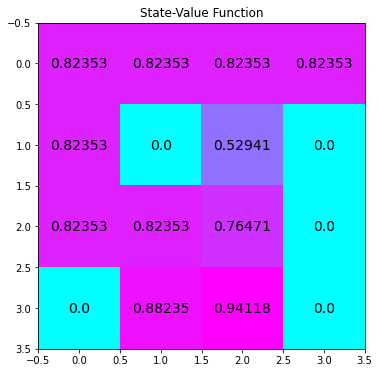

In [64]:
plot(V_vi)